In [51]:
!pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightkurve as lk
%matplotlib inline

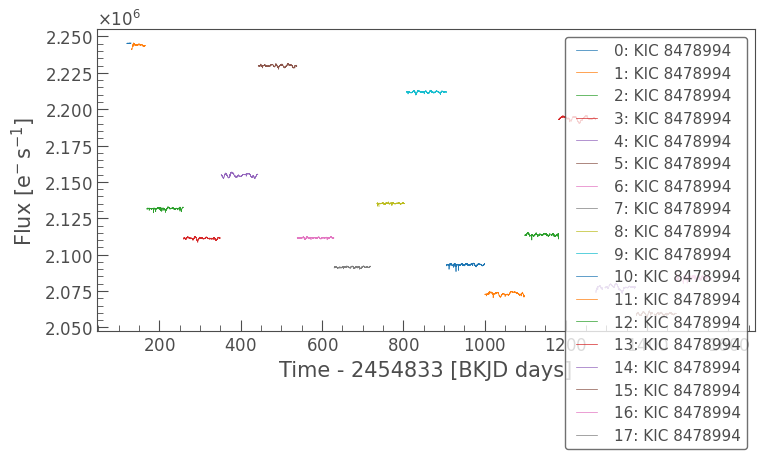

In [ ]:
# Search for Kepler observations of Kepler-37
search_result = lk.search_lightcurve('Kepler-37', author='Kepler', cadence='long')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
lc_collection.plot();

In [ ]:
search_result

SearchResult containing 18 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 00 2009 Kepler    1800 kplr008478994      0.0
  1 Kepler Quarter 01 2009 Kepler    1800 kplr008478994      0.0
  2 Kepler Quarter 02 2009 Kepler    1800 kplr008478994      0.0
  3 Kepler Quarter 03 2009 Kepler    1800 kplr008478994      0.0
  4 Kepler Quarter 04 2010 Kepler    1800 kplr008478994      0.0
  5 Kepler Quarter 05 2010 Kepler    1800 kplr008478994      0.0
  6 Kepler Quarter 06 2010 Kepler    1800 kplr008478994      0.0
  7 Kepler Quarter 07 2010 Kepler    1800 kplr008478994      0.0
  8 Kepler Quarter 08 2011 Kepler    1800 kplr008478994      0.0
  9 Kepler Quarter 09 2011 Kepler    1800 kplr008478994      0.0
 10 Kepler Quarter 10 2011 Kepler    1800 kplr008478994      0.0
 11 Kepler Quarter 11 2012 Kepler    1800 kplr008478994      0.0
 12 Kepler Quarter 12 2012 Kepler    1800 kplr008478994      0.0
 13 Kepler Quarter 13 2012 Kepler    1800 kplr008478994      0.0
 14 Kepler Quarter 14 2012 Kepler    1800 kplr008478994      0.0
 15 Kepler Quarter 15 2013 Kepler    1800 kplr008478994      0.0
 16 Kepler Quarter 16 2013 Kepler    1800 kplr008478994      0.0
 17 Kepler Quarter 17 2013 Kepler    1800 kplr008478994      0.0

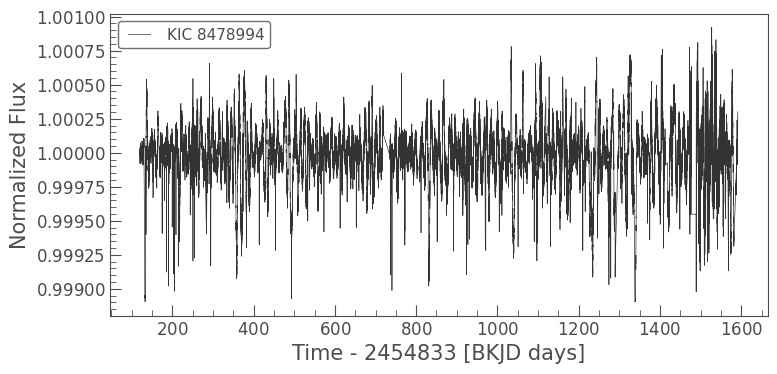

In [ ]:
# Flatten the light curve
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot();

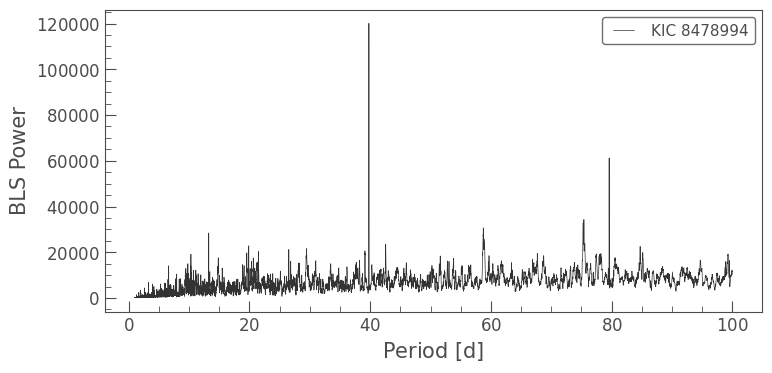

In [ ]:
import numpy as np
# Create array of periods to search
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<Quantity 39.79207921 d>

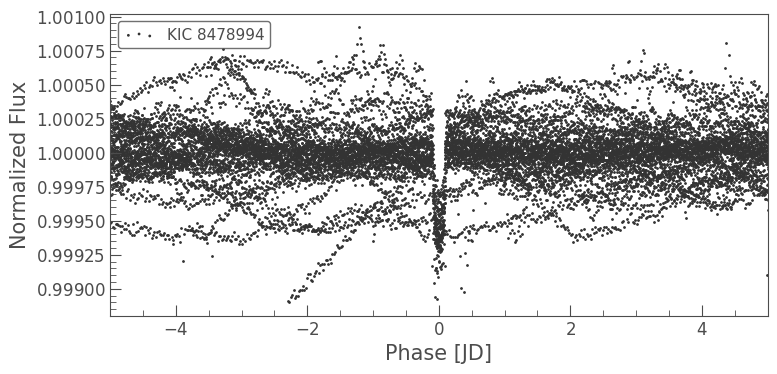

In [ ]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

In [ ]:
# Create a cadence mask using the BLS parameters
planet_b_mask = bls.get_transit_mask(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)

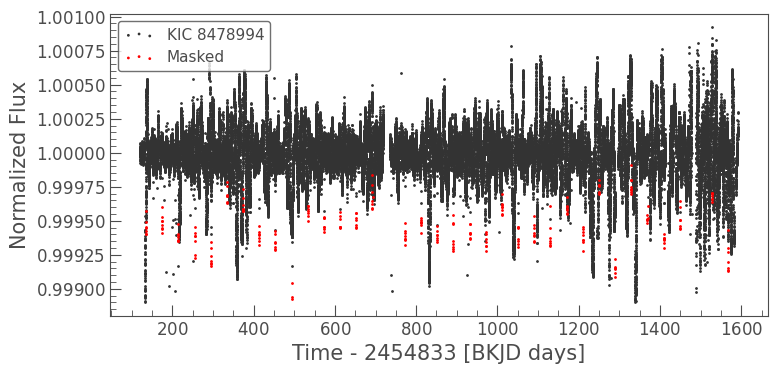

In [ ]:
masked_lc = lc[~planet_b_mask]
ax = masked_lc.scatter();
lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked');

In [ ]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

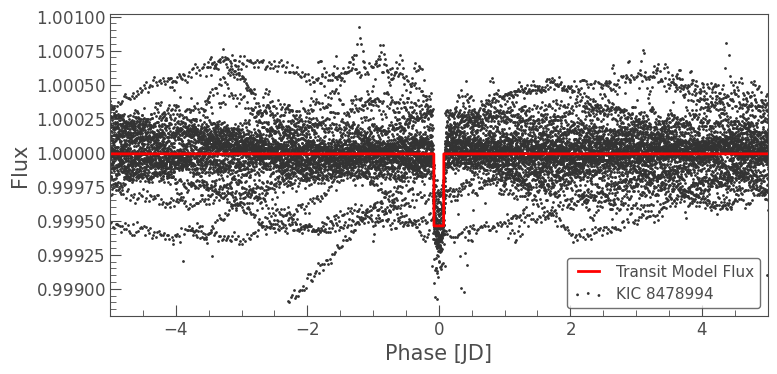

In [ ]:
ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5);

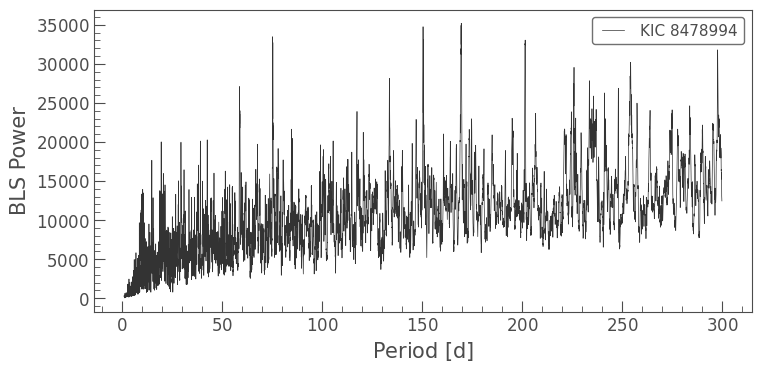

In [ ]:
period = np.linspace(1, 300, 10000)
bls = masked_lc.to_periodogram('bls', period=period, frequency_factor=500)
bls.plot();

In [ ]:
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 169.65286529 d>

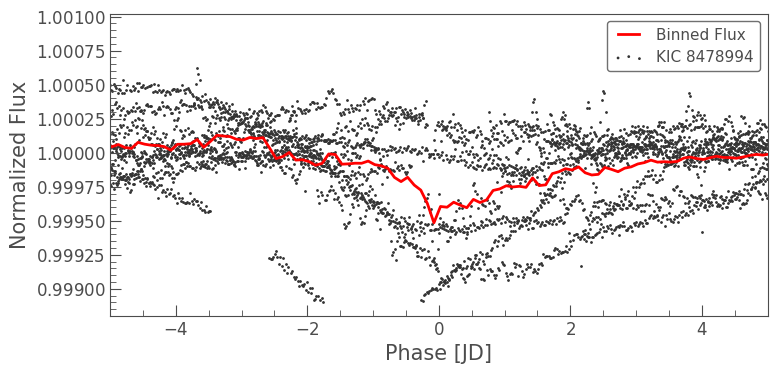

In [ ]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
ax.set_xlim(-5, 5);

In [ ]:
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

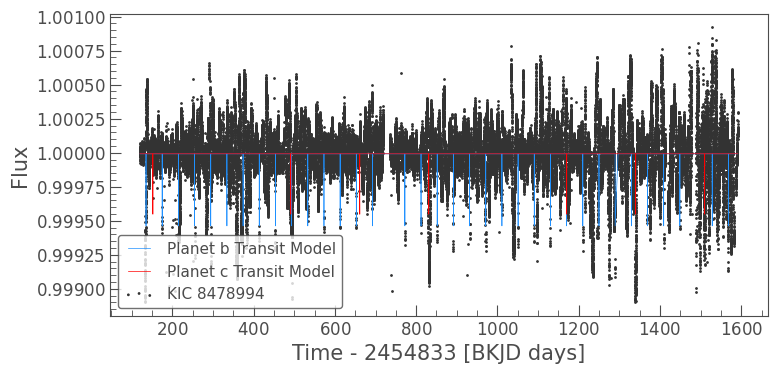

In [ ]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');


Now let's test my version of bls to calculate the period of a planet. First, lets import the code !


In [ ]:
import numpy as np

def normaliza(vetor):
    dp = np.std(vetor)
    media = np.mean(vetor)
    for i in range(len(vetor)):
        vetor[i] = (vetor[i] - media)/dp
    return vetor

# o peso é dado por uma parte comum, dado perto retorno abaixo
# para poupar processo computacional iremos realizar o calcul5o somente uma vez

def weightSoma(fluxErr):
    return np.power(np.sum(np.power(fluxErr,-2)),-1)

# o tempo relativo gasto na fase L é definido por r
# o mesmo pode ser calculado como segue abaixo

def rValue(i1,i2,weight):
    return np.sum(np.fromiter((weight[i] for i in range(i1,i2)), dtype=float))

def sValue(i1,i2,weight,fluxo):
    return np.sum(np.fromiter((weight[i]*fluxo[i] for i in range(i1,i2)), dtype=float))

def DValue(lisWeight,fluxo,r,s):
    soma = np.sum(np.fromiter((lisWeight[i]*fluxo[i]**2 for i in range(len(lisWeight))), dtype=float))
    return (soma - (s**2)/(r*(1-r)))

# função que calcula o BLS, dado o tempo e o fluxo
#  x[i] = fluxo
#  y[i] = fluxoErRO

def myBls(time,fluxo,fluxoErr):
    # fluxo é o eixo x
    # fluxoErr é o eixo y
    # time e fluxo devem ter o mesmo tamanho
    # if len(time) != len(fluxo):
    #     print("Erro: time e fluxo devem ter o mesmo tamanho")
    #     return -1
    # # vamos verificar se a curva está normalizada, se não iremos normalizar
    # if np.mean(fluxo) != 0 or np.std(fluxo) != 1:
    #     fluxo = normaliza(fluxo)
    # agora vamos iterar sobre a lista fluxo, calcular a reg linear
    # caso modulo do coeficiente suba muito, temos uma região de transito

    lisWeight = []
    menorD = None
    periodo = None
    somaW = weightSoma(fluxoErr)
    dataGraf = {}

    for i1 in range(len(fluxo)):
        wi = somaW*(fluxoErr[i1]**(-2))
        lisWeight.append(wi)

    for i1 in range(len(fluxo)):
        for i2 in range(i1+1,len(fluxo)):
            print(f"i1 {i1+1}, i2 = {i2+1}")
            r = rValue(i1,i2,lisWeight)
            s = sValue(i1,i2,lisWeight,fluxo)
            print(f"Flux has {len(fluxo)} length")
            d = DValue(lisWeight,fluxo,r,s)

            if i2 - i1 not in dataGraf:
                dataGraf[i2-i1] = [d]
            else:
                dataGraf[i2-i1].append(d)

            if menorD is None:
                menorD = d
                periodo = time[i2] - time[i1]
            elif d < menorD:
                periodo = time[i2] - time[i1]
            
    return periodo,dataGraf

Let's look how the lc object comes first

In [ ]:
lc

<KeplerLightCurve length=65093 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
120.53951885450078  1.0000074e+00 ... -6.4661135e-03  4.2580981e-03
120.55995322354283  9.9992239e-01 ... -6.5638712e-03  3.8885069e-03
120.58038749246771  9.9993962e-01 ... -5.9685106e-03  3.7506276e-03
120.60082196138683  9.9997753e-01 ... -5.9082387e-03  2.9275126e-03
120.62125633019605  9.9994457e-01 ... -5.2600387e-03  2.7429864e-03
120.64169059888809  9.9995100e-01 ... -4.8017814e-03  2.2730697e-03
120.66212496757362  9.9998486e-01 ... -4.9190526e-03  2.0690868e-03
120.68255943626718  9.9997371e-01 ... -4.7466517e-03  2.1154627e-03
 120.7029937047264  9.9997497e-01 ... -4.7704107e-03  2.0463706e-03
               ...            ... ...            ...            ...
1590.8180176153692  1.0001660e+00 ... -6.2673702e-03  1.1637992e-02
1590.8384521097323  1.0001486e+00 ... -6.2906025e-03  1.1601687e-02
1590.8588864040867  1.0001614e+00 ... -6.2763570e-03  1.1538830e-02
1590.8793207985073  1.0001855e+00 ... -6.1904974e-03  1.1825220e-02
1590.8997552928704  1.0001923e+00 ... -6.2535014e-03  1.1629740e-02
1590.9201895872247  1.0001745e+00 ... -6.3125128e-03  1.1451842e-02
1590.9406240815879  1.0002076e+00 ... -6.2049264e-03  1.1734735e-02
1590.9610584759503  1.0001852e+00 ... -6.2667262e-03  1.1538530e-02
1590.9814927703628  1.0002950e+00 ... -5.7840096e-03  1.2676445e-02
 1591.001927264726  1.0003010e+00 ... -6.1361925e-03  1.1771642e-02

In [ ]:
lc.time

<Time object: scale='tdb' format='bkjd' value=[ 120.53951885  120.55995322  120.58038749 ... 1590.96105848 1590.98149277
 1591.00192726]>

We are going to use the first, second and the third columns

In [ ]:
time = lc.time[:10]
flux = lc.flux[:10]
fluxErr = lc.flux_err[:10]

# calling the function
period,_ = myBls(time,flux,fluxErr)
print(f"The lowest period = {period} d")


i1 1, i2 = 2
Flux has 10 length
i1 1, i2 = 3
Flux has 10 length
i1 1, i2 = 4
Flux has 10 length
i1 1, i2 = 5
Flux has 10 length
i1 1, i2 = 6
Flux has 10 length
i1 1, i2 = 7
Flux has 10 length
i1 1, i2 = 8
Flux has 10 length
i1 1, i2 = 9
Flux has 10 length
i1 1, i2 = 10
Flux has 10 length
i1 2, i2 = 3
Flux has 10 length
i1 2, i2 = 4
Flux has 10 length
i1 2, i2 = 5
Flux has 10 length
i1 2, i2 = 6
Flux has 10 length
i1 2, i2 = 7
Flux has 10 length
i1 2, i2 = 8
Flux has 10 length
i1 2, i2 = 9
Flux has 10 length
i1 2, i2 = 10
Flux has 10 length
i1 3, i2 = 4
Flux has 10 length
i1 3, i2 = 5
Flux has 10 length
i1 3, i2 = 6
Flux has 10 length
i1 3, i2 = 7
Flux has 10 length
i1 3, i2 = 8
Flux has 10 length
i1 3, i2 = 9
Flux has 10 length
i1 3, i2 = 10
Flux has 10 length
i1 4, i2 = 5
Flux has 10 length
i1 4, i2 = 6
Flux has 10 length
i1 4, i2 = 7
Flux has 10 length
i1 4, i2 = 8
Flux has 10 length
i1 4, i2 = 9
Flux has 10 length
i1 4, i2 = 10
Flux has 10 length
i1 5, i2 = 6
Flux has 10 length
i1 5

Let´s use decimation to reduce the lightkurve and them test our function
For this, let's use: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [ ]:
teste = np.arange(0,100,1)
print(len(teste))

100


In [ ]:
from numpy.random import choice

p = [1/len(teste)]*len(teste)

decimado = choice(teste, 10, p)
decimado.sort()
print(decimado)
print(len(decimado))

[ 6 15 20 25 27 44 47 83 88 98]
10


Quanto maior o valor de q, maior será a divisão na lista. 
Se temos um total de 100, e q = 10, a lista final terá tamanho 100/10

In [ ]:
# sortear num entre 0 e len(vec) - 1
lisIdx = np.arange(0,len(lc.time),1)
lisProb = np.ones(shape=len(lisIdx),dtype=lisIdx.dtype)
lisProb = np.divide(lisProb,len(lisProb))
idxSort = choice(lisIdx, 100, p = lisProb)
idxSort.sort()

In [ ]:
idxSort[:5]

array([3483, 4764, 5074, 5346, 5634])

Vamos usar pandas para filtrar a curva de luz

In [ ]:
import pandas as pd

In [ ]:
lcReduced = lc.iloc[idxSort]

In [ ]:
lcReduced

<KeplerLightCurve length=100 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
 202.3573978675995  1.0000031e+00 ... -8.4977299e-03  3.1579837e-02
229.18647253389645  1.0000290e+00 ...  7.0508583e-03 -4.7165450e-02
236.66502528786805  9.9990445e-01 ...  3.1489231e-02 -5.0539143e-02
 242.2841357494035  1.0001112e+00 ...  3.1088786e-02 -6.9778293e-02
 248.3323236562428  1.0000426e+00 ...  8.2625575e-02 -4.4758033e-02
 285.7858030183852  9.9980384e-01 ...  1.0476221e-02 -1.4855801e-02
328.36777560049086  9.9982905e-01 ... -2.9460859e-02  3.4124706e-02
 355.7276281383238  9.9994241e-01 ...  8.4632725e-02 -8.7390117e-02
 357.6074826614422  9.9937066e-01 ...  8.0265582e-02 -8.3330549e-02
               ...            ... ...            ...            ...
1408.2235471673484  9.9992729e-01 ...  1.8657660e-02 -1.8026484e-02
1427.7572818377303  9.9986875e-01 ... -8.3068907e-03  7.8025106e-03
1433.1311147261804  1.0003476e+00 ... -1.4829186e-02  1.3927919e-02
1476.0608836638203  1.0004964e+00 ...  8.1169166e-02 -7.8934550e-02
1489.0156179779224  1.0001052e+00 ...  5.8485091e-02 -5.6919601e-02
1499.4367075815026  1.0000482e+00 ...  3.1356838e-02 -3.2031577e-02
1501.4596339967538  1.0000136e+00 ...  2.8860454e-02 -2.9137831e-02
1529.4743891973849  1.0004044e+00 ... -2.6482264e-02  2.8253600e-02
 1543.328693765594  9.9989050e-01 ... -5.0760765e-02  5.2086622e-02
1562.8638070986708  1.0000534e+00 ...  9.3707191e-03 -1.5086969e-02

In [ ]:
print(len(lcReduced))

100


Usando o metodo bls para estimar o periodo na curva reduzida

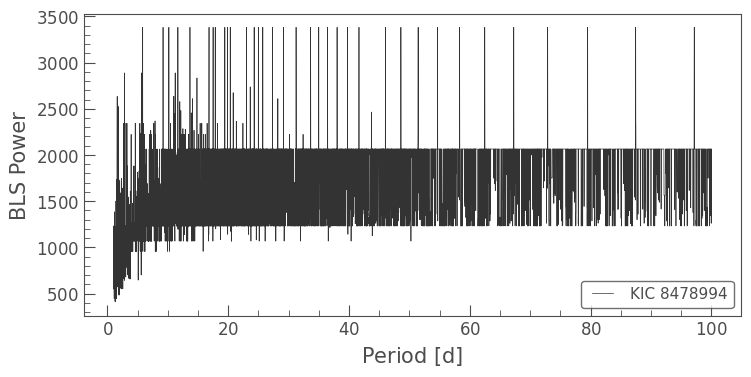

In [ ]:
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lcReduced.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
bls

BoxLeastSquaresPeriodogram(ID: KIC 8478994)

In [ ]:
periodLcRecudec = bls.period_at_max_power
periodLcRecudec

<Quantity 5.83168317 d>

Agora vamos usar o nosso methodo

In [ ]:
time = lcReduced.time
time

<Time object: scale='tdb' format='bkjd' value=[ 202.35739787  229.18647253  236.66502529  242.28413575  248.33232366
  285.78580302  328.3677756   355.72762814  357.60748266  359.22170755
  359.44647307  363.71702586  370.4804624   420.72705335  451.60317233
  461.77948269  466.17287487  512.33408429  526.59715372  537.44765066
  548.07327231  567.8531767   572.65508002  588.45017516  607.65743778
  624.14693383  651.83349933  699.83018137  708.39158504  717.77034651
  738.89829104  747.21469014  756.40978276  777.98781726  782.50371759
  784.60841764  790.18690715  811.66321322  817.75263132  821.59428365
  837.00179509  839.29044714  842.25343455  854.57537673  855.4131868
  862.91260525  871.94458924  880.38395839  902.20768044  915.85755721
  927.8522471   929.62998773  938.27345831  946.54907796  955.21289076
  966.9007909   977.36261812 1009.34027619 1023.76586951 1024.60361483
 1030.24306877 1045.28159993 1045.9150163  1048.50998076 1049.32729252
 1051.16624419 1074.35750865 108

In [ ]:
print(len(time))

100


In [ ]:
time = lcReduced.time
flux = lcReduced.flux
fluxErr = lcReduced.flux_err

# calling the function
period,dataDict = myBls(time,flux,fluxErr)
print(f"The lowest period = {period} d")

i1 1, i2 = 2
Flux has 100 length
i1 1, i2 = 3
Flux has 100 length
i1 1, i2 = 4
Flux has 100 length
i1 1, i2 = 5
Flux has 100 length
i1 1, i2 = 6
Flux has 100 length
i1 1, i2 = 7
Flux has 100 length
i1 1, i2 = 8
Flux has 100 length
i1 1, i2 = 9
Flux has 100 length
i1 1, i2 = 10
Flux has 100 length
i1 1, i2 = 11
Flux has 100 length
i1 1, i2 = 12
Flux has 100 length
i1 1, i2 = 13
Flux has 100 length
i1 1, i2 = 14
Flux has 100 length
i1 1, i2 = 15
Flux has 100 length
i1 1, i2 = 16
Flux has 100 length
i1 1, i2 = 17
Flux has 100 length
i1 1, i2 = 18
Flux has 100 length
i1 1, i2 = 19
Flux has 100 length
i1 1, i2 = 20
Flux has 100 length
i1 1, i2 = 21
Flux has 100 length
i1 1, i2 = 22
Flux has 100 length
i1 1, i2 = 23
Flux has 100 length
i1 1, i2 = 24
Flux has 100 length
i1 1, i2 = 25
Flux has 100 length
i1 1, i2 = 26
Flux has 100 length
i1 1, i2 = 27
Flux has 100 length
i1 1, i2 = 28
Flux has 100 length
i1 1, i2 = 29
Flux has 100 length
i1 1, i2 = 30
Flux has 100 length
i1 1, i2 = 31
Flux has

KeyboardInterrupt: ignored

In [ ]:
print(dataDict)

In [ ]:
eixoX = []
eixoY = []
for key in dataDict:
    lisD = dataDict[key]
    eixoX.append(key)
    eixoY.append(np.max(lisD))

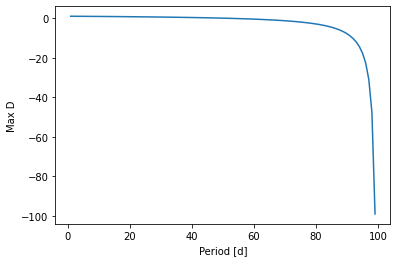

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eixoX,eixoY)
plt.xlabel("Period [d]")
plt.ylabel("Max D")
plt.show()

In [ ]:
# acessando os dados de frequencia da classe periodograma
bls.frequency

<Quantity [1.        , 0.99019608, 0.98058252, ..., 0.01000198, 0.01000099,
           0.01      ] 1 / d>

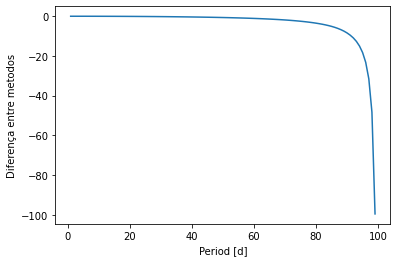

In [ ]:
delta = [eixoY[i] - np.array(bls.frequency[i]) for i in range(len(eixoY))]

plt.plot(eixoX,delta)
plt.xlabel("Period [d]")
plt.ylabel("Diferença entre metodos")
plt.show()

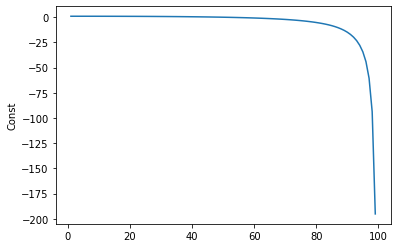

In [ ]:
const = [eixoY[i] / np.array(bls.frequency[i]) for i in range(len(eixoY))]

plt.plot(eixoX,const)
plt.ylabel("Const")
plt.show()

## Agora vamos refazer o processo sorteando 150 pontos


In [ ]:
# lisIdx = np.arange(0,len(lc.time),1)
# lisProb = np.ones(shape=len(lisIdx),dtype=lisIdx.dtype)
# lisProb = np.divide(lisProb,len(lisProb))
idxSort150 = choice(lisIdx, 150, p = lisProb)
idxSort150.sort()

In [ ]:
idxSort150[:5]

array([  89,  321,  415, 1412, 2401])

In [ ]:
lcReduced150 = lc.iloc[idxSort150]
lcReduced150

<KeplerLightCurve length=150 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
140.21776889868488  9.9997640e-01 ... -1.4834050e-02  1.9695722e-02
 144.5293947973987  9.9994117e-01 ... -6.5779239e-03  1.0707364e-02
 147.0223697203328  1.0000486e+00 ... -1.9543455e-03  4.2151213e-03
175.63004325459042  1.0000687e+00 ... -6.7857966e-02  8.9656517e-02
 192.6514137546037  9.9993449e-01 ... -6.1125349e-02  4.0835973e-02
205.46330010738166  9.9997533e-01 ... -6.0399026e-03  2.2826409e-02
210.46951142341277  1.0001888e+00 ... -2.8839123e-03  9.8550199e-03
214.47446852774738  9.9997203e-01 ...  1.6108371e-03 -6.6757976e-04
227.24531271528394  9.9997997e-01 ...  7.2857551e-03 -4.0944315e-02
               ...            ... ...            ...            ...
1507.4875629613598  1.0000467e+00 ...  1.5796617e-02 -1.6167099e-02
 1511.717345451667  1.0003295e+00 ...  7.3307641e-03 -7.4796919e-03
1526.3479904751803  1.0006646e+00 ... -4.8036124e-03  8.4867422e-03
 1536.953248424681  1.0005953e+00 ... -4.0550925e-02  4.2118959e-02
 1541.959606049546  9.9990301e-01 ... -4.9024798e-02  5.0450653e-02
 1561.637748605419  9.9985513e-01 ...  1.0813697e-02 -1.7216919e-02
1562.9864131432914  1.0001026e+00 ...  9.0806736e-03 -1.5123082e-02
1567.7476113841258  9.9938596e-01 ...  4.9115936e-03 -8.3648125e-03
 1572.181865410079  1.0000195e+00 ...  1.3228045e-03 -2.9777021e-03
 1576.227870384726  1.0002124e+00 ...  2.6664368e-04  5.8878306e-04

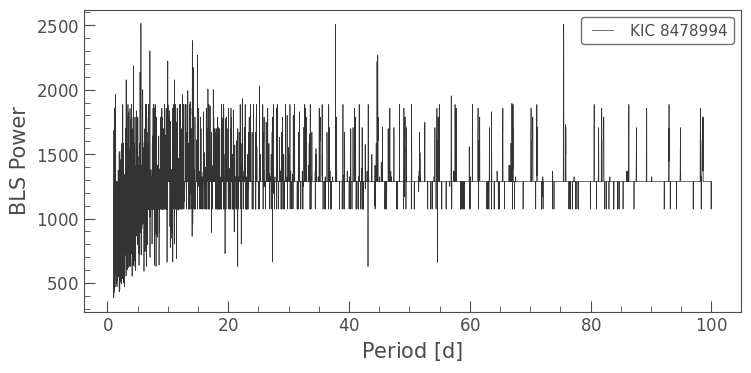

In [ ]:
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lcReduced150.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
periodLcRecudec150 = bls.period_at_max_power
periodLcRecudec150

<Quantity 5.54455446 d>

In [ ]:
time = lcReduced150.time
flux = lcReduced150.flux
fluxErr = lcReduced150.flux_err

# calling the function
period,dataDict = myBls(time,flux,fluxErr)
print(f"The lowest period = {period} d")

Streaming output truncated to the last 5000 lines.
Flux has 150 length
i1 79, i2 = 137
Flux has 150 length
i1 79, i2 = 138
Flux has 150 length
i1 79, i2 = 139
Flux has 150 length
i1 79, i2 = 140
Flux has 150 length
i1 79, i2 = 141
Flux has 150 length
i1 79, i2 = 142
Flux has 150 length
i1 79, i2 = 143
Flux has 150 length
i1 79, i2 = 144
Flux has 150 length
i1 79, i2 = 145
Flux has 150 length
i1 79, i2 = 146
Flux has 150 length
i1 79, i2 = 147
Flux has 150 length
i1 79, i2 = 148
Flux has 150 length
i1 79, i2 = 149
Flux has 150 length
i1 79, i2 = 150
Flux has 150 length
i1 80, i2 = 81
Flux has 150 length
i1 80, i2 = 82
Flux has 150 length
i1 80, i2 = 83
Flux has 150 length
i1 80, i2 = 84
Flux has 150 length
i1 80, i2 = 85
Flux has 150 length
i1 80, i2 = 86
Flux has 150 length
i1 80, i2 = 87
Flux has 150 length
i1 80, i2 = 88
Flux has 150 length
i1 80, i2 = 89
Flux has 150 length
i1 80, i2 = 90
Flux has 150 length
i1 80, i2 = 91
Flux has 150 length
i1 80, i2 = 92
Flux has 150 length
i1 80

In [ ]:
print(dataDict)

{1: [0.9931559103600484, 0.9931526503065243, 0.9931532451598256, 0.9932404785041984, 0.9932352317141575, 0.9932301624878171, 0.9932265921363795, 0.9932291964713246, 0.9932164120305659, 0.9932142756383509, 0.993220754049914, 0.9932186613985231, 0.9932273794822184, 0.9931127744301737, 0.9931149773631552, 0.9931142381954573, 0.9931065851929672, 0.9931129801600435, 0.9931149167787325, 0.9931141735100676, 0.9931154646650059, 0.9931172830930401, 0.9931011395195553, 0.993208126413858, 0.9932212894447695, 0.993221383190049, 0.9932031699449999, 0.9932059600340093, 0.9932115990151107, 0.9932019739176178, 0.9932073948816845, 0.9932056560574373, 0.9931910065009963, 0.99319258181952, 0.9931928457175071, 0.9931632367347373, 0.9931815487225566, 0.9931679981424542, 0.993177400100022, 0.9931671836375371, 0.9931626117797916, 0.9931677116078412, 0.9933108997998469, 0.993301507811838, 0.9932995032530361, 0.9932951099158702, 0.9933002689030366, 0.9932957175490603, 0.9932990073127003, 0.9932956403559541, 0.

In [ ]:
eixoX150 = []
eixoY150 = []
for key in dataDict:
    lisD = dataDict[key]
    eixoX150.append(key)
    eixoY150.append(np.max(lisD))

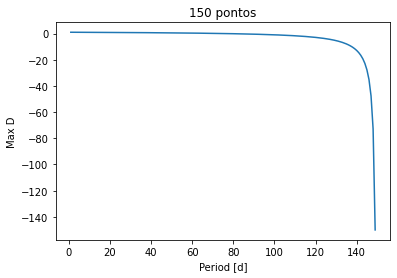

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eixoX150,eixoY150)
plt.title('150 pontos')
plt.xlabel("Period [d]")
plt.ylabel("Max D")
plt.show()

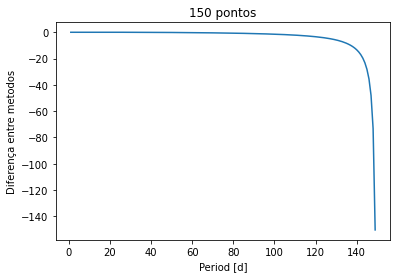

In [ ]:
delta150 = [eixoY150[i] - np.array(bls.frequency[i]) for i in range(len(eixoY150))]

plt.plot(eixoX150,delta150)
plt.title("150 pontos")
plt.xlabel("Period [d]")
plt.ylabel("Diferença entre metodos")
plt.show()

## Usando 200 pontos

In [ ]:
idxSort200 = choice(lisIdx, 200, p = lisProb)
idxSort200.sort()

In [ ]:
idxSort200[:5]

array([ 125, 1013, 1425, 1798, 2123])

In [ ]:
lcReduced200 = lc.iloc[idxSort200]
lcReduced200

<KeplerLightCurve length=200 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
123.09381401821156  9.9998397e-01 ... -4.2794128e-03  2.5171367e-03
144.36592102821305  9.9996108e-01 ... -6.5546022e-03  1.0823623e-02
152.90741501323646  9.9991180e-01 ...  7.8776460e-03 -1.1101889e-02
 160.5906452787749  9.9989096e-01 ...  2.3422036e-02 -2.9023647e-02
 172.0541033294503  9.9999267e-01 ... -6.7470171e-02  1.0218833e-01
176.95824755055946  9.9998736e-01 ... -6.8141639e-02  8.5488014e-02
189.46375149646337  1.0000205e+00 ... -6.2731169e-02  4.9114827e-02
198.45457769435598  1.0001262e+00 ... -5.8266081e-02  2.4457118e-02
207.62925465075386  9.9995905e-01 ... -4.7575529e-03  1.7218500e-02
               ...            ... ...            ...            ...
   1436.4208030554  1.0003036e+00 ... -1.2556437e-02  1.0281402e-02
1443.9809687473535  9.9994187e-01 ... -2.5038281e-02  2.3439636e-02
1464.2505044041827  9.9976032e-01 ... -5.3213038e-02  5.2038886e-02
1469.6857191691306  1.0001127e+00 ... -6.1722070e-02  6.1388552e-02
1504.2590418828113  1.0000772e+00 ...  2.3138659e-02 -2.3378354e-02
1515.9675741000392  1.0002283e+00 ... -2.1063215e-03  2.0552306e-03
1531.5177900556664  9.9999767e-01 ... -3.0477623e-02  3.1896256e-02
1537.2188916816522  1.0005695e+00 ... -4.0413015e-02  4.1925233e-02
1538.0566893657378  1.0003266e+00 ... -4.2179514e-02  4.3670669e-02
1543.9621526358096  9.9984651e-01 ... -5.1853240e-02  5.3205956e-02

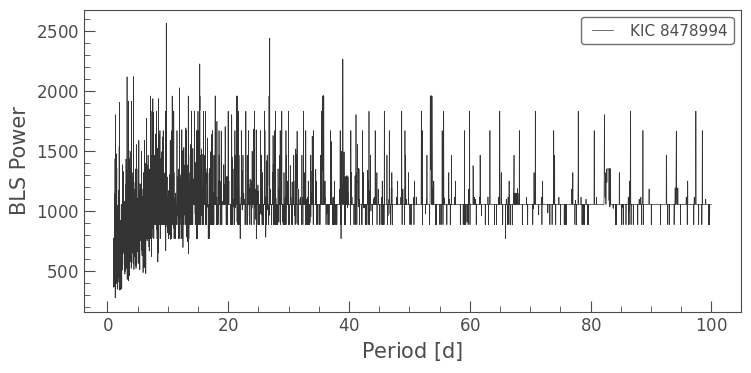

In [ ]:
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lcReduced200.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
periodLcRecudec200 = bls.period_at_max_power
periodLcRecudec200

<Quantity 9.74257426 d>

In [ ]:
time = lcReduced200.time
flux = lcReduced200.flux
fluxErr = lcReduced200.flux_err

# calling the function
period,dataDict = myBls(time,flux,fluxErr)
print(f"The lowest period = {period} d")

Streaming output truncated to the last 5000 lines.
Flux has 200 length
i1 129, i2 = 187
Flux has 200 length
i1 129, i2 = 188
Flux has 200 length
i1 129, i2 = 189
Flux has 200 length
i1 129, i2 = 190
Flux has 200 length
i1 129, i2 = 191
Flux has 200 length
i1 129, i2 = 192
Flux has 200 length
i1 129, i2 = 193
Flux has 200 length
i1 129, i2 = 194
Flux has 200 length
i1 129, i2 = 195
Flux has 200 length
i1 129, i2 = 196
Flux has 200 length
i1 129, i2 = 197
Flux has 200 length
i1 129, i2 = 198
Flux has 200 length
i1 129, i2 = 199
Flux has 200 length
i1 129, i2 = 200
Flux has 200 length
i1 130, i2 = 131
Flux has 200 length
i1 130, i2 = 132
Flux has 200 length
i1 130, i2 = 133
Flux has 200 length
i1 130, i2 = 134
Flux has 200 length
i1 130, i2 = 135
Flux has 200 length
i1 130, i2 = 136
Flux has 200 length
i1 130, i2 = 137
Flux has 200 length
i1 130, i2 = 138
Flux has 200 length
i1 130, i2 = 139
Flux has 200 length
i1 130, i2 = 140
Flux has 200 length
i1 130, i2 = 141
Flux has 200 length
i1 1

In [ ]:
print(dataDict)

{1: [0.99485378425208, 0.9949053678166236, 0.9949034043827643, 0.9949079961852189, 0.9949645834251487, 0.9949696499125497, 0.994967519306893, 0.9949641377828575, 0.9949595257016117, 0.9949602820073219, 0.9949599138268546, 0.9949601746492288, 0.9949600102679859, 0.9949570254761343, 0.9949546125275687, 0.9949489215064183, 0.9949533663523655, 0.9949525478681668, 0.9949601610433846, 0.9949486265646886, 0.9948640632447162, 0.9948736840704312, 0.9948744036275387, 0.9948691149143734, 0.9948770821912724, 0.9948737299042585, 0.9948703000509141, 0.9948791496283431, 0.9948783043679545, 0.994876047089234, 0.9948758013577705, 0.9948743392583048, 0.9948668987509414, 0.994948255299383, 0.994947455360732, 0.9949471901334476, 0.9949463205768502, 0.9949451049708712, 0.9949468784744115, 0.9949488499492201, 0.9949212225145976, 0.9949258613504508, 0.9949410880633398, 0.9949420488910932, 0.9949360873558675, 0.9949308687902955, 0.9949249179937264, 0.9949241350656404, 0.9949217312009427, 0.9949153395614593, 0

In [ ]:
eixoX200 = []
eixoY200 = []
for key in dataDict:
    lisD = dataDict[key]
    eixoX200.append(key)
    eixoY200.append(np.max(lisD))

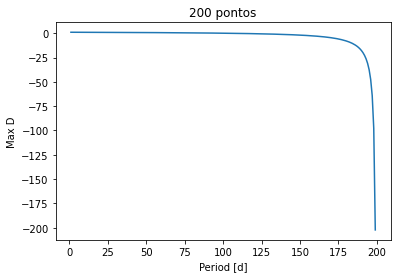

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eixoX200,eixoY200)
plt.title('200 pontos')
plt.xlabel("Period [d]")
plt.ylabel("Max D")
plt.show()

## comparando os graficos em um mesmo plot

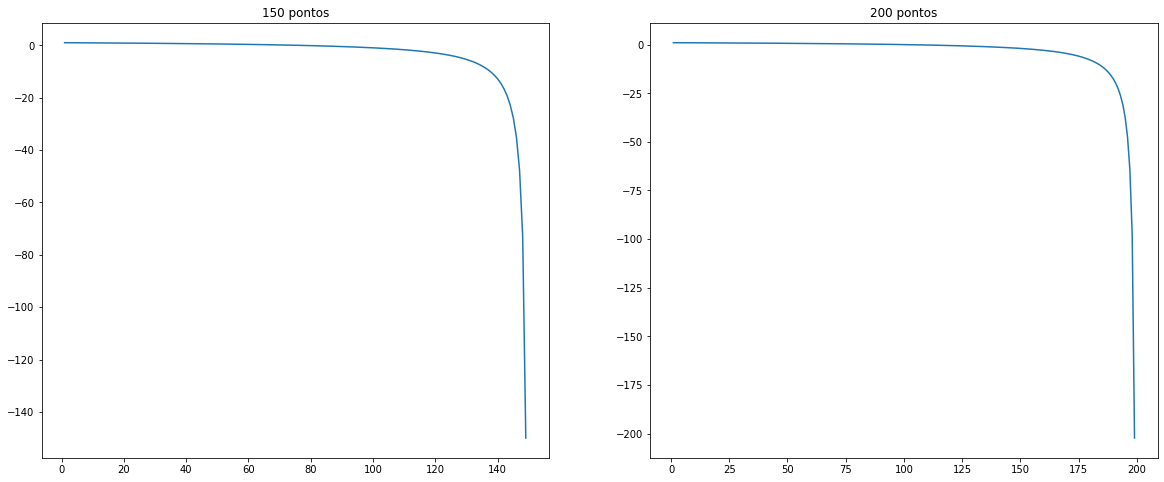

In [ ]:
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.plot(eixoX150,eixoY150)
plt.title("150 pontos")

plt.subplot(1,2,2)
plt.plot(eixoX200,eixoY200)
plt.title("200 pontos")

plt.show()

## Agora vamos testar o metodo com 500 pontos, depois 750 e por fim 1000 pontos

In [ ]:
idxSort500 = choice(lisIdx, 500, p = lisProb)
idxSort500.sort()

In [ ]:
idxSort500[:5]

array([165, 518, 527, 540, 726])

In [ ]:
lcReduced500 = lc.iloc[idxSort500]
lcReduced500

<KeplerLightCurve length=500 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
123.93162259970268  9.9998164e-01 ... -2.0815821e-03  1.6448082e-03
134.16922142531257  9.9943262e-01 ... -2.6354391e-02  3.0853106e-02
134.35313016214786  9.9956708e-01 ... -2.6199749e-02  3.0924525e-02
134.63921019959525  9.9967602e-01 ... -2.6205698e-02  2.8613232e-02
 138.4604218778768  1.0002013e+00 ... -1.8725468e-02  2.3717834e-02
 139.6660438901672  1.0000074e+00 ... -1.6174972e-02  1.9810880e-02
  141.832075180806  9.9989474e-01 ... -1.1959803e-02  1.7058471e-02
143.56898587144678  9.9986565e-01 ... -8.4506590e-03  1.3271384e-02
156.62642884239904  1.0000578e+00 ...  1.4563032e-02 -2.1464286e-02
               ...            ... ...            ...            ...
 1561.862526006007  9.9990874e-01 ...  1.0580014e-02 -1.6561687e-02
1563.2520591554348  1.0001495e+00 ...  8.6157760e-03 -1.4602696e-02
 1566.071995703598  9.9998630e-01 ...  6.1020139e-03 -1.0620083e-02
1568.9941061885183  9.9983921e-01 ...  3.5988421e-03 -6.6831168e-03
1578.7412989951408  1.0002452e+00 ... -1.1298170e-03  2.8408275e-03
1579.0069460099185  1.0001352e+00 ... -9.3173457e-04  2.8316909e-03
1580.7847376266145  9.9943579e-01 ... -2.1830669e-03  4.4601839e-03
1587.1193914450705  9.9976590e-01 ... -1.3269928e-02  1.2229966e-02
1587.4463418297382  9.9983809e-01 ... -1.2291704e-02  1.2933615e-02
1589.7758633063277  9.9997878e-01 ... -6.8200938e-03  1.1757701e-02

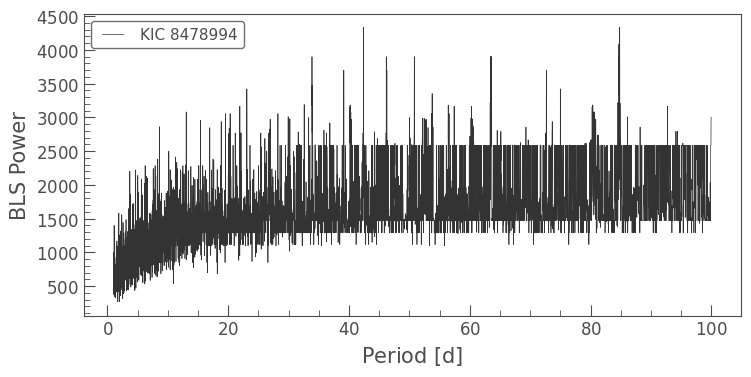

In [ ]:
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lcReduced500.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
periodLcRecudec500 = bls.period_at_max_power
periodLcRecudec500

<Quantity 84.8019802 d>

In [ ]:
time = lcReduced500.time
flux = lcReduced500.flux
fluxErr = lcReduced500.flux_err

# calling the function
period,dataDict = myBls(time,flux,fluxErr)
print(f"The lowest period = {period} d")

Streaming output truncated to the last 5000 lines.
Flux has 500 length
i1 429, i2 = 487
Flux has 500 length
i1 429, i2 = 488
Flux has 500 length
i1 429, i2 = 489
Flux has 500 length
i1 429, i2 = 490
Flux has 500 length
i1 429, i2 = 491
Flux has 500 length
i1 429, i2 = 492
Flux has 500 length
i1 429, i2 = 493
Flux has 500 length
i1 429, i2 = 494
Flux has 500 length
i1 429, i2 = 495
Flux has 500 length
i1 429, i2 = 496
Flux has 500 length
i1 429, i2 = 497
Flux has 500 length
i1 429, i2 = 498
Flux has 500 length
i1 429, i2 = 499
Flux has 500 length
i1 429, i2 = 500
Flux has 500 length
i1 430, i2 = 431
Flux has 500 length
i1 430, i2 = 432
Flux has 500 length
i1 430, i2 = 433
Flux has 500 length
i1 430, i2 = 434
Flux has 500 length
i1 430, i2 = 435
Flux has 500 length
i1 430, i2 = 436
Flux has 500 length
i1 430, i2 = 437
Flux has 500 length
i1 430, i2 = 438
Flux has 500 length
i1 430, i2 = 439
Flux has 500 length
i1 430, i2 = 440
Flux has 500 length
i1 430, i2 = 441
Flux has 500 length
i1 4

In [ ]:
print(dataDict)

{1: [0.9979057293404155, 0.9979263763309418, 0.9979254869163386, 0.9979255422894429, 0.9979280259638481, 0.9979288807929364, 0.997927405350763, 0.9979261321039036, 0.9979249054995674, 0.997927900478695, 0.9979280560715178, 0.9979237229186712, 0.9979468457894665, 0.9979501917557817, 0.9979520939265781, 0.997952009756745, 0.9979479135042352, 0.9979516703249216, 0.9979513333700688, 0.9979509510218693, 0.9979500579945197, 0.9979498230623869, 0.9979499096057948, 0.9979495768889335, 0.9979483713455879, 0.9979488389149447, 0.9979488250555105, 0.9979487350512456, 0.9979489572146323, 0.9979496063877799, 0.997949651036293, 0.9979467318035664, 0.9979457805776859, 0.9979454445488456, 0.9979450894255875, 0.9979469091711632, 0.9979465091892628, 0.9979459969046375, 0.9979152257349556, 0.99791529006809, 0.9979156844586475, 0.9979144540551349, 0.9979153573527055, 0.997914994774881, 0.9979132716961979, 0.997913669420786, 0.9979153705145637, 0.9979147018178671, 0.9979149957097038, 0.9979131930811009, 0.9

In [ ]:
eixoX500 = []
eixoY500 = []
for key in dataDict:
    lisD = dataDict[key]
    eixoX500.append(key)
    eixoY500.append(np.max(lisD))

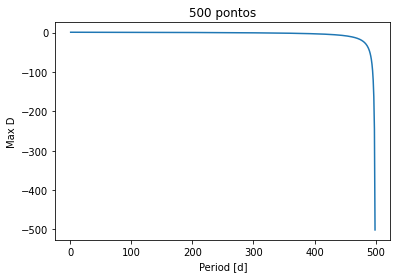

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eixoX500,eixoY500)
plt.title('500 pontos')
plt.xlabel("Period [d]")
plt.ylabel("Max D")
plt.show()

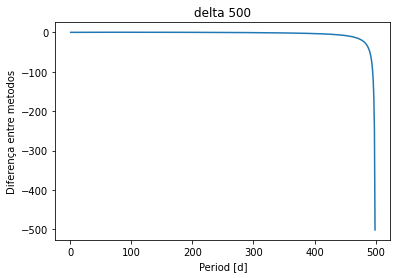

In [ ]:
delta500 = [eixoY500[i] - np.array(bls.frequency[i]) for i in range(len(eixoY500))]

plt.plot(eixoX500,delta500)
plt.title("delta 500")
plt.xlabel("Period [d]")
plt.ylabel("Diferença entre metodos")
plt.show()

## agora com 750 pontos

In [ ]:
idxSort750 = choice(lisIdx, 750, p = lisProb)
idxSort750.sort()

In [ ]:
lcReduced750 = lc.iloc[idxSort750]
lcReduced750

<KeplerLightCurve length=750 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
121.45906529073545  9.9999398e-01 ... -4.8623853e-03  2.3634045e-03
123.76814784587623  9.9993831e-01 ... -2.4130433e-03  1.8346577e-03
125.60723933789268  1.0000179e+00 ...  5.4863916e-04 -1.6047021e-04
128.83586495356576  9.9997139e-01 ...  6.7128236e-03 -2.8974558e-03
129.40802616781002  9.9997258e-01 ...  6.3900733e-03 -4.3559531e-03
129.53063215305883  9.9999118e-01 ...  6.4895302e-03 -4.2193462e-03
136.80524517629237  1.0004947e+00 ... -2.1740390e-02  2.6151765e-02
138.19477626244043  1.0001936e+00 ... -1.9374438e-02  2.4079623e-02
 138.4808561551763  1.0001885e+00 ... -1.8764773e-02  2.3582438e-02
               ...            ... ...            ...            ...
 1572.181865410079  1.0000195e+00 ...  1.3228045e-03 -2.9777021e-03
1573.2035834744092  9.9957938e-01 ...  1.2434437e-03 -2.0965196e-03
1573.8983520374532  9.9933030e-01 ...  5.6302152e-04 -1.3313090e-03
1574.7565954086385  9.9941790e-01 ...  6.5618777e-05 -5.2611227e-04
1576.1052640647104  1.0001634e+00 ...  2.1952335e-04  5.9798954e-04
1576.1256984345528  1.0002176e+00 ...  2.4038454e-04  5.9663062e-04
1578.5573895980924  1.0003024e+00 ... -1.3544676e-03  2.7878294e-03
1580.0082309153295  9.9978730e-01 ... -1.6003564e-03  3.8811986e-03
1580.9277782071586  9.9936976e-01 ... -2.2514535e-03  4.5351521e-03
 1587.241997801335  9.9978188e-01 ... -1.2993261e-02  1.2837343e-02

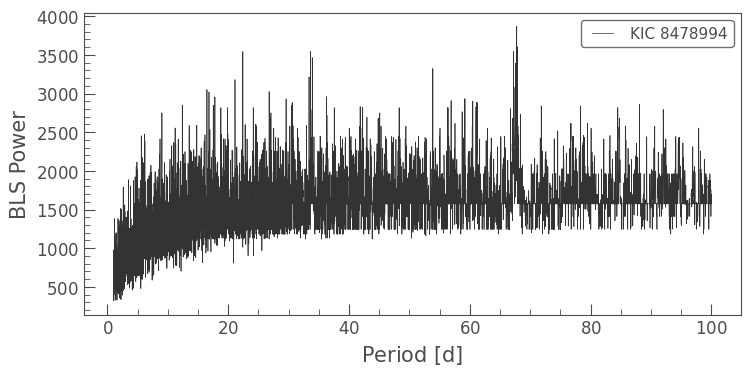

In [ ]:
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lcReduced750.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
periodLcRecudec750 = bls.period_at_max_power
periodLcRecudec750

<Quantity 67.76237624 d>

In [ ]:
time = lcReduced750.time
flux = lcReduced750.flux
fluxErr = lcReduced750.flux_err

# calling the function
period,dataDict = myBls(time,flux,fluxErr)
print(f"The lowest period = {period} d")

Streaming output truncated to the last 5000 lines.
Flux has 750 length
i1 679, i2 = 737
Flux has 750 length
i1 679, i2 = 738
Flux has 750 length
i1 679, i2 = 739
Flux has 750 length
i1 679, i2 = 740
Flux has 750 length
i1 679, i2 = 741
Flux has 750 length
i1 679, i2 = 742
Flux has 750 length
i1 679, i2 = 743
Flux has 750 length
i1 679, i2 = 744
Flux has 750 length
i1 679, i2 = 745
Flux has 750 length
i1 679, i2 = 746
Flux has 750 length
i1 679, i2 = 747
Flux has 750 length
i1 679, i2 = 748
Flux has 750 length
i1 679, i2 = 749
Flux has 750 length
i1 679, i2 = 750
Flux has 750 length
i1 680, i2 = 681
Flux has 750 length
i1 680, i2 = 682
Flux has 750 length
i1 680, i2 = 683
Flux has 750 length
i1 680, i2 = 684
Flux has 750 length
i1 680, i2 = 685
Flux has 750 length
i1 680, i2 = 686
Flux has 750 length
i1 680, i2 = 687
Flux has 750 length
i1 680, i2 = 688
Flux has 750 length
i1 680, i2 = 689
Flux has 750 length
i1 680, i2 = 690
Flux has 750 length
i1 680, i2 = 691
Flux has 750 length
i1 6

# plot dos resultados


In [ ]:
eixoX750 = []
eixoY750 = []
for key in dataDict:
    lisD = dataDict[key]
    eixoX750.append(key)
    eixoY750.append(np.max(lisD))


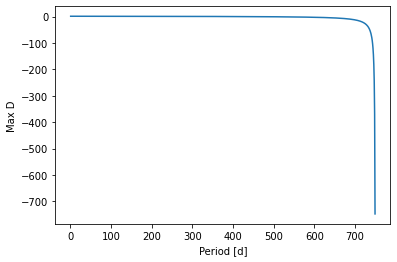

In [ ]:
plt.plot(eixoX750,eixoY750)
plt.xlabel("Period [d]")
plt.ylabel("Max D")
plt.show()

In [ ]:
bls.frequency

<Quantity [1.        , 0.99019608, 0.98058252, ..., 0.01000198, 0.01000099,
           0.01      ] 1 / d>

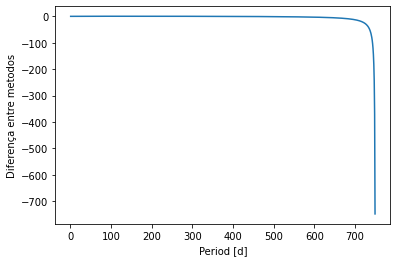

In [ ]:
delta750 = [eixoY750[i] - np.array(bls.frequency[i]) for i in range(len(eixoY750))]

plt.plot(eixoX750,delta750)
plt.xlabel("Period [d]")
plt.ylabel("Diferença entre metodos")
plt.show()

#finalmente, com 1000 pontos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
idxSort1000 = choice(lisIdx, 2000, p = lisProb)
idxSort1000.sort()

print(f'escolhemos {len(idxSort1000)} pontos')

#salvando os ids em um arquivo para backup
with open('lisIdx.csv','w') as f:
    for data in idxSort1000:
        f.write(str(data)+' ')

escolhemos 2000 pontos


In [ ]:
with open('/content/gdrive/MyDrive/logArthur/lisIdx.csv','r') as f:
    lista = f.read()

print(lista)

29 125 148 170 193 218 256 265 270 281 321 335 339 342 350 386 464 556 621 688 809 817 836 840 845 932 963 1061 1065 1190 1207 1210 1224 1230 1304 1361 1363 1389 1395 1396 1443 1517 1550 1586 1639 1642 1678 1682 1689 1705 1719 1764 1768 1779 1868 1887 1902 1912 1961 2002 2006 2035 2040 2055 2072 2205 2214 2302 2330 2335 2359 2374 2389 2413 2482 2534 2545 2580 2587 2626 2659 2677 2700 2744 2782 2812 2829 2844 2846 2887 2920 2961 2984 3025 3026 3048 3123 3132 3136 3188 3191 3199 3221 3224 3320 3443 3623 3686 3758 3793 3800 3819 3854 3856 3875 3895 3926 3930 3992 4103 4117 4137 4158 4159 4164 4179 4199 4199 4201 4270 4278 4315 4315 4319 4407 4443 4453 4470 4501 4569 4583 4631 4644 4657 4669 4693 4737 4773 4853 4859 4874 4895 4895 5152 5164 5180 5186 5202 5218 5290 5309 5313 5385 5387 5402 5476 5500 5536 5645 5648 5649 5720 5730 5789 5814 5918 5950 5974 5978 5992 6026 6073 6106 6138 6149 6181 6205 6269 6361 6368 6383 6409 6434 6454 6474 6493 6497 6512 6574 6587 6666 6673 6681 6693 6761 677

In [ ]:
dados = lista.split()
print(dados)
print(f'escolhemos {len(dados)} pontos')

['29', '125', '148', '170', '193', '218', '256', '265', '270', '281', '321', '335', '339', '342', '350', '386', '464', '556', '621', '688', '809', '817', '836', '840', '845', '932', '963', '1061', '1065', '1190', '1207', '1210', '1224', '1230', '1304', '1361', '1363', '1389', '1395', '1396', '1443', '1517', '1550', '1586', '1639', '1642', '1678', '1682', '1689', '1705', '1719', '1764', '1768', '1779', '1868', '1887', '1902', '1912', '1961', '2002', '2006', '2035', '2040', '2055', '2072', '2205', '2214', '2302', '2330', '2335', '2359', '2374', '2389', '2413', '2482', '2534', '2545', '2580', '2587', '2626', '2659', '2677', '2700', '2744', '2782', '2812', '2829', '2844', '2846', '2887', '2920', '2961', '2984', '3025', '3026', '3048', '3123', '3132', '3136', '3188', '3191', '3199', '3221', '3224', '3320', '3443', '3623', '3686', '3758', '3793', '3800', '3819', '3854', '3856', '3875', '3895', '3926', '3930', '3992', '4103', '4117', '4137', '4158', '4159', '4164', '4179', '4199', '4199', '42

In [ ]:
listaIdx1000 = [int(x) for x in dados]

print(listaIdx1000)
print(f'escolhemos {len(listaIdx1000)} pontos')

[29, 125, 148, 170, 193, 218, 256, 265, 270, 281, 321, 335, 339, 342, 350, 386, 464, 556, 621, 688, 809, 817, 836, 840, 845, 932, 963, 1061, 1065, 1190, 1207, 1210, 1224, 1230, 1304, 1361, 1363, 1389, 1395, 1396, 1443, 1517, 1550, 1586, 1639, 1642, 1678, 1682, 1689, 1705, 1719, 1764, 1768, 1779, 1868, 1887, 1902, 1912, 1961, 2002, 2006, 2035, 2040, 2055, 2072, 2205, 2214, 2302, 2330, 2335, 2359, 2374, 2389, 2413, 2482, 2534, 2545, 2580, 2587, 2626, 2659, 2677, 2700, 2744, 2782, 2812, 2829, 2844, 2846, 2887, 2920, 2961, 2984, 3025, 3026, 3048, 3123, 3132, 3136, 3188, 3191, 3199, 3221, 3224, 3320, 3443, 3623, 3686, 3758, 3793, 3800, 3819, 3854, 3856, 3875, 3895, 3926, 3930, 3992, 4103, 4117, 4137, 4158, 4159, 4164, 4179, 4199, 4199, 4201, 4270, 4278, 4315, 4315, 4319, 4407, 4443, 4453, 4470, 4501, 4569, 4583, 4631, 4644, 4657, 4669, 4693, 4737, 4773, 4853, 4859, 4874, 4895, 4895, 5152, 5164, 5180, 5186, 5202, 5218, 5290, 5309, 5313, 5385, 5387, 5402, 5476, 5500, 5536, 5645, 5648, 5649, 5

In [ ]:
lcReduced1000 = lc.iloc[listaIdx1000]
lcReduced1000

<KeplerLightCurve length=2000 LABEL="KIC 8478994" QUARTER=17 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float64     ...    float32        float32    
------------------ -------------- ... -------------- --------------
121.13211542766658  9.9999553e-01 ... -5.4890867e-03  8.9216488e-04
123.09381401821156  9.9998397e-01 ... -4.2794128e-03  2.5171367e-03
123.58423862894415  9.9999231e-01 ... -2.3069910e-03  2.0872396e-03
 124.0337944807543  9.9994934e-01 ... -1.4507970e-03  1.3241655e-03
124.50378454619931  9.9996281e-01 ... -1.7694037e-03  1.3734515e-04
 125.0146432703259  1.0000037e+00 ... -8.5709087e-04  4.9242709e-04
125.81158282642718  1.0000019e+00 ...  1.0676990e-03  2.2167769e-04
125.99549195837608  1.0000242e+00 ...  9.7788800e-04 -4.2418350e-04
126.09766359518835  1.0000153e+00 ...  6.7139999e-04 -1.3018415e-03
               ...            ... ...            ...            ...
1581.2138596748773  9.9938770e-01 ... -2.3796647e-03  4.7772224e-03
1581.4182036142884  9.9931281e-01 ... -2.4164221e-03  4.9558645e-03
1587.0989569524536  9.9976065e-01 ... -1.3393169e-02  1.2010811e-02
1588.8358808814883  1.0000188e+00 ... -8.2447231e-03  1.1408842e-02
1589.6328224471508  9.9998247e-01 ... -6.9853049e-03  1.1279318e-02
1589.6328224471508  9.9998247e-01 ... -6.9853049e-03  1.1279318e-02
 1590.061944825451  1.0000374e+00 ... -6.6980147e-03  1.1718917e-02
1590.1641168967835  1.0000609e+00 ... -6.6024773e-03  1.1772248e-02
1590.2458544739347  1.0000358e+00 ... -6.6134525e-03  1.1652816e-02
1590.9814927703628  1.0002950e+00 ... -5.7840096e-03  1.2676445e-02

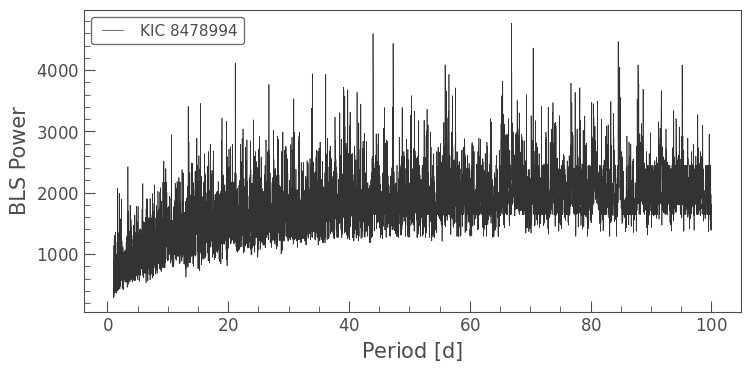

In [ ]:
period = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
bls = lcReduced1000.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
periodLcRecudec1000 = bls.period_at_max_power
periodLcRecudec1000

<Quantity 66.92079208 d>

In [ ]:
with open('teste.csv','a') as f:
    f.write('i1,i2,d')
    f.write('\n')
    for i in range(10):
        f.write(str(i)+',' + str(i) +',' + str(i) + '\n')

with open('teste.csv','r') as f:
    linhas = f.readlines()
    for l in linhas:
        print(l.split())

['i1,i2,d']
['0,0,0']
['1,1,1']
['2,2,2']
['3,3,3']
['4,4,4']
['5,5,5']
['6,6,6']
['7,7,7']
['8,8,8']
['9,9,9']


In [52]:
dfteste = pd.read_csv('/content/gdrive/MyDrive/logArthur/data.csv')
dfteste.tail()

ParserError: ignored

# ajustando a função para gravar em um arquivo

In [ ]:
with open('data.csv', 'a') as f:
    f.write('i1,i2,d')
    f.write('\n')

In [ ]:
import os

In [ ]:
def myBls(time,fluxo,fluxoErr):
    lisWeight = []
    somaW = weightSoma(fluxoErr)

    for i1 in range(len(fluxo)):
        wi = somaW*(fluxoErr[i1]**(-2))
        lisWeight.append(wi)

    for i1 in range(946,len(fluxo)):
        for i2 in range(i1+1,len(fluxo)):
            print(f"i1 {i1+1}, i2 = {i2+1}")
            r = rValue(i1,i2,lisWeight)
            s = sValue(i1,i2,lisWeight,fluxo)
            d = DValue(lisWeight,fluxo,r,s)

            with open('/content/gdrive/MyDrive/logArthur/data.csv', 'a') as f:
                f.write(str(i1)+',' + str(i2) +',' + str(d) + '\n')
        os.system("google-drive-ocamlfuse -cc")

In [ ]:
time = lcReduced1000.time
flux = lcReduced1000.flux
fluxErr = lcReduced1000.flux_err

myBls(time,flux,fluxErr)

A saída de streaming foi truncada nas últimas 5000 linhas.
i1 1005, i2 = 1222
i1 1005, i2 = 1223
i1 1005, i2 = 1224
i1 1005, i2 = 1225
i1 1005, i2 = 1226
i1 1005, i2 = 1227
i1 1005, i2 = 1228
i1 1005, i2 = 1229
i1 1005, i2 = 1230
i1 1005, i2 = 1231
i1 1005, i2 = 1232
i1 1005, i2 = 1233
i1 1005, i2 = 1234
i1 1005, i2 = 1235
i1 1005, i2 = 1236
i1 1005, i2 = 1237
i1 1005, i2 = 1238
i1 1005, i2 = 1239
i1 1005, i2 = 1240
i1 1005, i2 = 1241
i1 1005, i2 = 1242
i1 1005, i2 = 1243
i1 1005, i2 = 1244
i1 1005, i2 = 1245
i1 1005, i2 = 1246
i1 1005, i2 = 1247
i1 1005, i2 = 1248
i1 1005, i2 = 1249
i1 1005, i2 = 1250
i1 1005, i2 = 1251
i1 1005, i2 = 1252
i1 1005, i2 = 1253
i1 1005, i2 = 1254
i1 1005, i2 = 1255
i1 1005, i2 = 1256
i1 1005, i2 = 1257
i1 1005, i2 = 1258
i1 1005, i2 = 1259
i1 1005, i2 = 1260
i1 1005, i2 = 1261
i1 1005, i2 = 1262
i1 1005, i2 = 1263
i1 1005, i2 = 1264
i1 1005, i2 = 1265
i1 1005, i2 = 1266
i1 1005, i2 = 1267
i1 1005, i2 = 1268
i1 1005, i2 = 1269
i1 1005, i2 = 1270
i1 1005, i

In [ ]:
# dfDados = pd.read_csv('data.csv')
# dfDados.tail()

from google.colab import files
files.download('data.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dfDados['dif'] = dfDados['i2'] - dfDados['i1']
print(len(dfDados))
dfDados.head()

124750


i1  i2         d  dif
0   0   1  0.997907    1
1   0   2  0.995834    2
2   0   3  0.993779    3
3   0   4  0.991714    4
4   0   5  0.989642    5

In [ ]:
dataDic1000 = {}

with open('data.csv', 'r') as f:
    lines = f.readlines()
    for i in range(1,len(lines)):
        line = lines[i]
        i1,i2,d = line.split(',')
        i1 = int(i1)
        i2 = int(i2)
        d = float(d.split()[0])
        dif = i2 - i1
        if dif not in dataDic1000:
            dataDic1000[dif] = [d]
        else:
            dataDic1000[dif].append(d)

In [ ]:
dataDic1000

{1: [0.9979066481984133,
  0.9979074119129597,
  0.9979334408818423,
  0.9979330345369686,
  0.9979330016618149,
  0.9979335824977182,
  0.9979337546033538,
  0.9979316207231627,
  0.9979304335332266,
  0.9979249968210644,
  0.9979494628323899,
  0.9979533481629056,
  0.9979549270945326,
  0.9979549874183844,
  0.9979566238410881,
  0.9979562157726992,
  0.9979575857485051,
  0.9979579860895951,
  0.9979581147864371,
  0.9979583149115878,
  0.9979573170760816,
  0.997956728631978,
  0.9979344708723374,
  0.9979584426773591,
  0.9979566308475407,
  0.9979560189484045,
  0.9979557601008342,
  0.9979545025453477,
  0.9979552539812737,
  0.9979547343202018,
  0.9979547476859663,
  0.9979539103412756,
  0.9979538141750877,
  0.997952971738682,
  0.9979526524993325,
  0.9979528143890581,
  0.9979525692295238,
  0.9979530075435527,
  0.9979525963980939,
  0.997952535039568,
  0.9979523670411529,
  0.9979514498210338,
  0.9979507975684495,
  0.9979565553293832,
  0.997956611338916,
  0.9979548

#plot dos resultados

In [ ]:
eixoX1000 = []
eixoY1000 = []
for key in dataDic1000:
    lisD = dataDic1000[key]
    eixoX1000.append(key)
    eixoY1000.append(np.max(lisD))

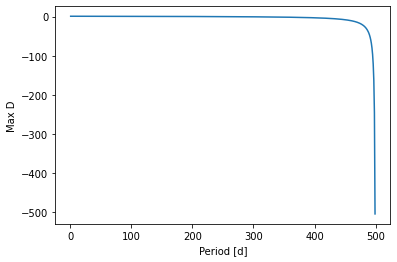

constant = -3.946736374998458


In [ ]:
import matplotlib.pyplot as plt

plt.plot(eixoX1000,eixoY1000)
plt.xlabel("Period [d]")
plt.ylabel("Max D")
plt.show()

media = np.sum(eixoY1000[:599])
media = np.divide(media,600)
print(f'constant = {media}')

In [ ]:
bls.frequency

<Quantity [1.        , 0.99019608, 0.98058252, ..., 0.01000198, 0.01000099,
           0.01      ] 1 / d>

In [ ]:
delta1000 = [eixoY1000[i] / np.array(bls.frequency[i]) for i in range(len(eixoY1000))]

plt.plot(eixoX1000,delta1000)
plt.xlabel("Period [d]")
plt.ylabel("Diferença entre metodos")
plt.show()

media = np.sum(delta1000[:399])
media = np.divide(media,400)
print(f'constant = {media}')